In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
from sklearn.linear_model import LogisticRegression
import itertools


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.optimize import minimize
from sklearn.metrics import log_loss

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
data = pd.read_json("data/train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)

In [4]:
#data['request_length']=data.apply(lambda x: len(x['request_text']), axis=1).astype(int)

In [4]:
data.shape

(4040, 27)

In [36]:
data.head(1)

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_number_of_comments_at_retrieval,request_text,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,...,requester_received_pizza,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,year,month,day,dayofweek,request_length
0,0,1,0,0,Hi I am in need of food for my 4 children we a...,0,792,0,792,0,...,False,0,1,0,1,2011,10,5,2,316


In [5]:
data.requester_account_age_in_days_at_request=data.requester_account_age_in_days_at_request.astype(int)
data.requester_account_age_in_days_at_retrieval=data.requester_account_age_in_days_at_retrieval.astype(int)
data.requester_days_since_first_post_on_raop_at_retrieval=data.requester_days_since_first_post_on_raop_at_retrieval.astype(int)
data.requester_days_since_first_post_on_raop_at_request=data.requester_days_since_first_post_on_raop_at_request.astype(int)

In [8]:
data.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True      994
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

#data=data[data.requester_received_pizza!=True].iloc[::3].append(data[data.requester_received_pizza==True])
print (data[data.requester_received_pizza!=True].shape)
print (data[data.requester_received_pizza==True].shape)

train_data, dev_data = train_test_split(data, test_size=0.3)
train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

(3046, 27)
(994, 27)
(2828, 25)
(2828,)
(1212, 25)
(1212,)


In [161]:
print (len([1 for k in train_labels if k==True])/len(train_labels))
print (len([1 for k in dev_labels if k==True])/len(dev_labels))

0.5031982942430704
0.47429519071310117


In [9]:
class_names = ['No-Pizza','Pizza']
import string
def better_preprocessor(s):
    if len(s)>1: 
      for char in string.punctuation:
         s = s.replace(char, ' ').lower()
    elif (s.isdigit()):
        s = ' '
    else: s=' '        
    return s

In [7]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = str_input.split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [10]:
#Computing the vocabulary of training data
t_vectorizer = CountVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                     ,tokenizer=stemming_tokenizer,
                     )
t_vectorizer.fit(train_data_text) 
t_vocabulary=t_vectorizer.get_feature_names()
print('Size of Training vocabulary : '+str(len(t_vocabulary)))

#Computing the vocabulary of dev data
d_vectorizer = CountVectorizer(stop_words='english',
                     preprocessor=better_preprocessor,
                     tokenizer=stemming_tokenizer,
                     )
d_vectorizer.fit(dev_data_text) 
d_vocabulary=d_vectorizer.get_feature_names()
print('\nSize of Dev vocabulary : '+str(len(d_vocabulary)))

#Computing the common elements features
intersection=len(list(set(t_vocabulary) & set(d_vocabulary)))
print('Size of common vocabulary : '+str(intersection))

Size of Training vocabulary : 7640

Size of Dev vocabulary : 4968
Size of common vocabulary : 3417


In [191]:
print('Fraction of the words in the dev data are missing from the training vocabulary : '+str((len(d_vocabulary)-intersection)/len(t_vocabulary)))

Fraction of the words in the dev data are missing from the training vocabulary : 0.20301047120418847


In [119]:
vectorizer = TfidfVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                     #,tokenizer=stemming_tokenizer
                      ,min_df=2, 
                      max_df=0.5, 
                     ngram_range=(1,1)       
                     )
X = vectorizer.fit_transform(train_data_text)
print (len(vectorizer.get_feature_names()))

4744


In [ ]:
vocabulary=list(set(vocabulary)

In [120]:
#Fit Logistic Regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='lbfgs',C=0.21,
multi_class='multinomial',class_weight='balanced').fit(X,train_labels)
features=vectorizer.get_feature_names()

In [121]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = clf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)


F1 Score for Logistic Regression Classifier : 0.679391604654214


[[630 298]
 [111 173]]


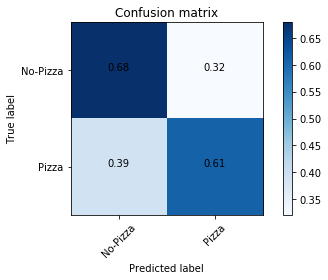

In [178]:
print (confusion_matrix(dev_labels,predicted))
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [123]:
from sklearn.grid_search import GridSearchCV

param_range=[0.0001,0.0005,0.001]
parameters = {'C': param_range, 'solver':['lbfgs'] }

gs_clf=GridSearchCV(clf, parameters, cv=5, iid=False, n_jobs=-1,scoring='roc_auc')
gs_clf = gs_clf.fit(X, train_labels)

In [124]:
gs_clf.best_params_

{'C': 0.001, 'solver': 'lbfgs'}

In [125]:
y_test=dev_labels

gs_clf = gs_clf.best_estimator_
predicted = gs_clf.predict(X_dev)
f=metrics.f1_score(y_test, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)
print('LogLoss : {score}'.format(score=log_loss(y_test, predicted)))


F1 Score for Logistic Regression Classifier : 0.6854275340993006
LogLoss : 11.655608766957647


In [126]:
dev_probs=gs_clf.predict_proba(X_dev)
predicted=[True if dev_probs[k][1] > 0.50 else False for k in range(len(dev_probs))]

[[630 298]
 [111 173]]


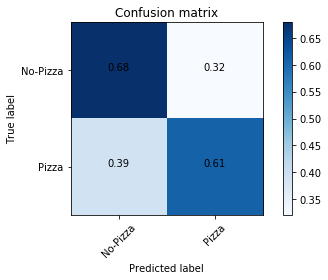

In [180]:
print (confusion_matrix(dev_labels,predicted))
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [16]:
c=confusion_matrix(dev_labels,predicted)
c[0][1]+c[1][0]

434

In [629]:
def loss_func(weight):
    predicted=[True if dev_probs[k][1] > weight else False for k in range(len(dev_probs))]
    c=confusion_matrix(dev_labels,predicted)
    return (c[0][1]+c[1][0])-2*c[1][1]
    #return metrics.recall_score(dev_probabilities, final_prediction)

In [630]:
starting_values = [0.30]

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0.30,0.55)]

res = minimize(loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 228.0
Best Weights: [0.55]


In [20]:
lr_clf=gs_clf

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

y=train_labels
X=train_data
class_weight='balanced'
rfclf = RandomForestClassifier(n_estimators=300,max_features='sqrt',max_depth=80,min_samples_leaf=1,bootstrap=True,min_samples_split=11,class_weight=class_weight)
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=11, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [161]:
X_test=dev_data
y_test=dev_labels
y_pred = rfclf.predict(X_test)
print('Accuracy of classifier on dev set: {:.2f}'.format(rfclf.score(X_test, y_test)))
print('LogLoss : {score}'.format(score=log_loss(y_test, y_pred)))

Accuracy of classifier on dev set: 0.85
LogLoss : 5.215071324127486


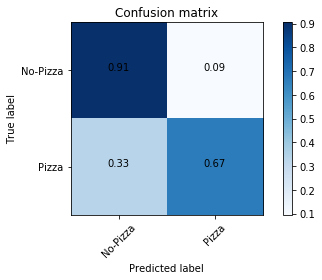

In [162]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test,y_pred), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [106]:
predictions=[]
predictions.append(rfclf.predict_proba(X_test))

In [107]:
X_dev = vectorizer.transform(dev_data_text)

predictions.append(gs_clf.predict_proba(X_dev))

In [26]:
dev_probabilities=[int(k) for k in dev_labels]

In [27]:
def log_loss_func(weights):
    final_prediction = 0
    ''' scipy minimize will pass the weights as a numpy array '''
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(dev_probabilities, final_prediction)
    #return metrics.recall_score(dev_probabilities, final_prediction)

In [108]:
starting_values = [0.5]*len(predictions)

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 0.35010244197087953
Best Weights: [1.00000000e+00 1.11022302e-16]


In [163]:
#weights=res['x']
weights=starting_values
y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(dev_data))]
y_pred=[True if k > 0.43 else False for k in y_pred]

In [164]:
print('LogLoss : {score}'.format(score=log_loss(dev_labels, y_pred)))

LogLoss : 6.526005713190925


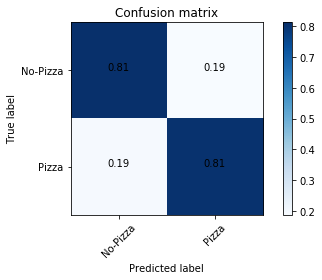

In [182]:
plot_confusion_matrix(confusion_matrix(dev_labels,y_pred), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

## End of Analysis

In [903]:
dev_data_text.iloc[0]

"Just moved into a new apartment with my GF and we've spent all our monies on the moving truck, ridiculous deposits, down payments, and other 'security' fees. Payday is a few days away but we're really craving a good pizza. Can Reddit help us settle in tonight?"

In [906]:
dev_data_text_new=[dev_data_text.iloc[i] for i in range(len(dev_labels)) if dev_labels.iloc[i]==True and y_pred[i]==False]
dev_labels_new=[dev_labels.iloc[i] for i in range(len(dev_labels)) if dev_labels.iloc[i]==True and y_pred[i]==False]

In [907]:
X_dev_new = vectorizer.transform(dev_data_text_new)
dev_probs=gs_clf.predict_proba(X_dev_new)
predicted=[True if dev_probs[k][1] > 0.50 else False for k in range(len(dev_probs))]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


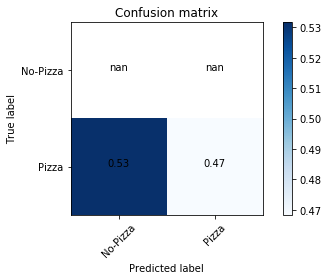

In [908]:
plot_confusion_matrix(confusion_matrix(dev_labels_new,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [693]:
def loss_func1(weight):
    y_pred=[weights[0]*predictions[0][k][1]+weights[1]*predictions[1][k][1] for k in range(len(dev_data))]
    y_pred=[True if k > 0.41 else False for k in y_pred]
    c=confusion_matrix(dev_labels,y_pred)
    return (c[0][1]/(c[0][1]+c[0][0])+c[1][0]/(c[1][0]+c[1][1]))
    #return metrics.recall_score(dev_probabilities, final_prediction)

In [694]:
starting_values = [0.30]

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0.30,0.55)]

res = minimize(loss_func1, starting_values, method='SLSQP', bounds=bounds)

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 0.4476176228588526
Best Weights: [0.3]


In [730]:
wclf = svm.SVC(kernel='linear', class_weight={True: 3})
wclf.fit(X,train_labels)
features=vectorizer.get_feature_names()

In [731]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = wclf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for SVM Classifier : %r' % f)


F1 Score for SVM Classifier : 0.6695040932664694


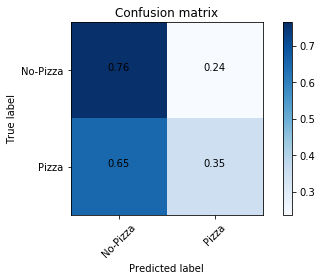

In [732]:
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [733]:
wclf.get_params().keys()

dict_keys(['cache_size', 'tol', 'max_iter', 'kernel', 'degree', 'class_weight', 'verbose', 'random_state', 'coef0', 'probability', 'decision_function_shape', 'C', 'shrinking', 'gamma'])

In [738]:
from sklearn.grid_search import GridSearchCV

parameters = {
     'class_weight': ['balanced'],
     'C': param_range
}

param_range=[10,11,12,15]

gs_clf=GridSearchCV(wclf, parameters, cv=5, iid=False, n_jobs=-1,scoring='f1')
gs_clf = gs_clf.fit(X, train_labels)

In [739]:
gs_clf.best_params_

{'C': 11, 'class_weight': 'balanced'}

In [740]:
X_dev = vectorizer.transform(dev_data_text)

gs_clf = gs_clf.best_estimator_
predicted = gs_clf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score  : %r' % f)


F1 Score  : 0.6682332187074586


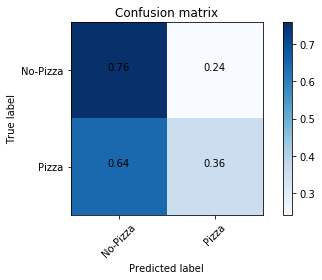

In [741]:
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [742]:
svm_clf=gs_clf

In [ ]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = wclf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for SVM Classifier : %r' % f)

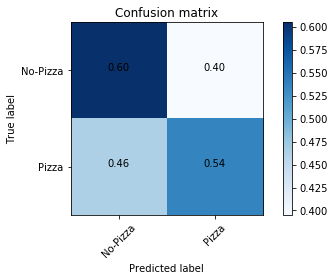

In [343]:
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [726]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                     )
X = vectorizer.fit_transform(train_data_text)

print (len(vectorizer.get_feature_names()))
#'alpha': 0.001, 'l1_ratio': 0.05, 'loss': 'hinge', 'penalty': 'l1'}
clf = RandomForestClassifier(n_estimators=300,max_features='sqrt',max_depth=80,min_samples_leaf=1,bootstrap=True,min_samples_split=11,class_weight='balanced')
clf.fit(X,train_labels).fit(X,train_labels)
features=vectorizer.get_feature_names()

10255


In [727]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = clf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)


F1 Score for Logistic Regression Classifier : 0.6698832446094404


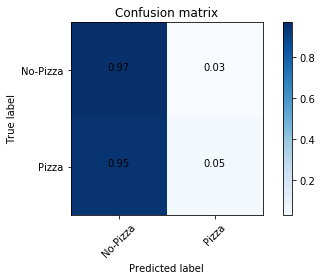

In [728]:
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [714]:
from sklearn.neural_network import MLPClassifier

vectorizer = CountVectorizer(stop_words='english',
                     preprocessor=better_preprocessor
                             
                     )
X = vectorizer.fit_transform(train_data_text)

print (len(vectorizer.get_feature_names()))
#'alpha': 0.001, 'l1_ratio': 0.05, 'loss': 'hinge', 'penalty': 'l1'}
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100,20,10,5, 2), random_state=1)
clf.fit(X,train_labels).fit(X,train_labels)
features=vectorizer.get_feature_names()

10255


In [715]:
from sklearn import metrics

X_dev = vectorizer.transform(dev_data_text)
predicted = clf.predict(X_dev)
f=metrics.f1_score(dev_labels, predicted, average='weighted')
print ('\nF1 Score for Logistic Regression Classifier : %r' % f)


F1 Score for Logistic Regression Classifier : 0.6802369838902687


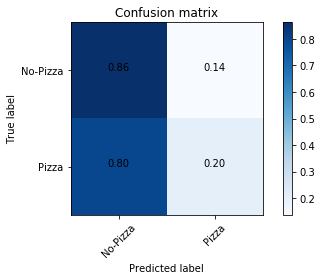

In [716]:
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [787]:
#Get 5 largest features for each label 
features=vectorizer.get_feature_names()
largest_features=[]
for i in range(1):
    table=list(enumerate(clf.coef_[i]))
    s_table = sorted(table, key=lambda x: x[1], reverse=True)[0:1000]
    largest_features.extend([ (i,j) for (i,j) in s_table])

In [788]:
largest_features

[(1569, 0.556016572763597),
 (1816, 0.5502017303398002),
 (1011, 0.4782194769667441),
 (2644, 0.4325642162940674),
 (3891, 0.43222659298282085),
 (1963, 0.43093692583694143),
 (1893, 0.41067096557445276),
 (794, 0.41058219276264907),
 (2090, 0.4033547147424174),
 (4246, 0.38047044174379957),
 (3169, 0.3774582132602474),
 (3976, 0.3745290436038683),
 (2022, 0.3743042633890039),
 (3330, 0.36644937160627467),
 (3008, 0.35700795798663904),
 (2162, 0.35489270552170976),
 (4118, 0.3489720030182525),
 (4032, 0.3458894533886521),
 (3313, 0.3444932690366587),
 (4097, 0.3444371689808972),
 (1376, 0.3426158529961745),
 (4125, 0.3421141435894083),
 (1258, 0.3405864997022881),
 (217, 0.3382917052160885),
 (1186, 0.33611618392061177),
 (3536, 0.33512893867901133),
 (904, 0.3331545091409925),
 (3165, 0.333055525887515),
 (3389, 0.32935696167207534),
 (3969, 0.3275019650586125),
 (3485, 0.32706740032774695),
 (3077, 0.32644292408181147),
 (1742, 0.3258711197860975),
 (1670, 0.3252697902693494),
 (4077

In [789]:
largest_features_names=[{features[i]:j} for i,j in largest_features]
len(largest_features_names)

1000

In [772]:
largest_features_names

[{'girl': 0.3577246655943988},
 {'father': 0.3437082213396453},
 {'edit': 0.2807799406170712},
 {'stay': 0.2776073190149476},
 {'thought': 0.27635374654404465},
 {'rice': 0.26763178699066303},
 {'currently': 0.26696907247682594},
 {'helping': 0.26081076463972347},
 {'request': 0.25311770918414744},
 {'cover': 0.24923917390016875},
 {'surprise': 0.23948678194246759},
 {'unemployed': 0.2324832138396783},
 {'chicago': 0.22844857543669},
 {'happen': 0.2281020578756574},
 {'says': 0.22809644236012389},
 {'paycheck': 0.22800465105163376},
 {'hospital': 0.22551905938324926},
 {'person': 0.22165424270030853},
 {'does': 0.21650138863210977},
 {'mentioned': 0.21301340589057066},
 {'ve unemployed': 0.20687502284748766},
 {'details': 0.20343138391467036},
 {'sound': 0.20195795845165765},
 {'sunday': 0.2001969747137221},
 {'bucks': 0.19918515255299177},
 {'pockets': 0.19752595112936536},
 {'state': 0.19600300286976094},
 {'date': 0.19206257072542046},
 {'greatest': 0.19184399063662935},
 {'daughter

In [434]:
dev_data_text[:1]

1398    I am so hungry, me and my roommate have had on...
Name: request_text, dtype: object

In [522]:
dev_probs=lr_clf.predict_proba(X_dev)

In [524]:
dev_probabilities=[int(k) for k in dev_labels]
misses= [{dev_data_text.iloc[k]:dev_probs[k][1]} for k in range(len(dev_probs)) if list(dev_labels)[k]==False and predicted[k]==True]
list(misses)[1:10]

[{"Just an idea but I was wondering if anyone would be interested in ordering pizza's for the paralyzed veterans at the VA in ST Louis? A lot of the patients are older gentleman with no family and some of them end up staying for months or even years. I saw this reddit and recently [posted a story](http://www.reddit.com/r/funny/comments/up8ap/then_why_the_hell_did_you_give_it_to_me/c4xdiq2) about my roommate in a different sub, saw this sub and made me thank of him.\n\nI was there for 4 months late last year and Remember the sunday dinners where the worst. If you are interested they eat dinner at 5PM CST, so if we ordered at 4PM it should arrive before they get dinner.\n\nJefferson Barracks SCI unit, Building 52 , St. Louis, MO 63125 \n\n(be sure to put a note to deliver to nurses station and say it's for the vets and nurses if you want, the nurses there are pretty awesome and have a thankless job)\n\nIf anyone needs the correct numbers to call, let me know. I just thought they would be

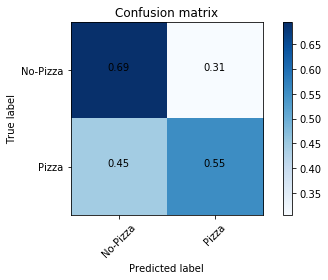

In [526]:
plot_confusion_matrix(confusion_matrix(dev_labels,predicted), classes=class_names,normalize=True,
                      title='Confusion matrix')
plt.show()

In [184]:
cv=vectorizer
final_model=gs_clf
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}

In [188]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:2000]:
   print (best_positive)

('edit', 0.006543965027869838)
('ve', 0.005268284611158792)
('thanks', 0.0051418189948175515)
('days', 0.00484789908913088)
('thank', 0.0047817491094177544)
('imgur', 0.004388983960078339)
('nice', 0.004185164496615608)
('http', 0.004148976638071149)
('com', 0.004046601147454987)
('got', 0.004019198632823264)
('paycheck', 0.003944934226846993)
('rice', 0.003900548460872407)
('request', 0.0036392034057721005)
('week', 0.0034883056407824633)
('tight', 0.0034770310052854468)
('work', 0.0034755557122731155)
('food', 0.003434096672598241)
('recently', 0.003182155303540384)
('weeks', 0.003135296476947843)
('people', 0.0030628046846444593)
('pay', 0.0029743101173529064)
('forward', 0.0029298357307644203)
('offer', 0.0027618391456932464)
('jpg', 0.002742194960474511)
('helping', 0.002726804856343918)
('car', 0.002586347427619206)
('tonight', 0.0025554140728391234)
('able', 0.0025528147426400424)
('life', 0.002522213621256279)
('hello', 0.0024948539483323094)
('paid', 0.0024724961557892927)
('c

('narrow', 8.401208469648624e-05)
('open', 8.390572294835597e-05)
('abuse', 8.371209679706769e-05)
('cleveland', 8.342790717495123e-05)
('extended', 8.338191754423251e-05)
('supportive', 8.32970186905024e-05)
('slight', 8.317015267532973e-05)
('typo', 8.285405848449096e-05)
('failing', 8.248819453587072e-05)
('bless', 8.241170648146921e-05)
('cash', 8.200575452271683e-05)
('solo', 8.171406706789587e-05)
('disposable', 8.127583583829835e-05)
('scared', 8.123440025840115e-05)
('28', 8.11580608349919e-05)
('practice', 8.099430467969226e-05)
('underneath', 8.070418899432409e-05)
('cherry', 8.059378736730495e-05)
('26th', 8.052843013762013e-05)
('fafsa', 8.04469476589628e-05)
('split', 7.99224479516715e-05)
('head', 7.98617363938938e-05)
('affect', 7.96897007216983e-05)
('stir', 7.967055332131375e-05)
('terminal', 7.962466391815748e-05)
('hung', 7.947612444879664e-05)
('excuse', 7.928451018666656e-05)
('14th', 7.864283481443295e-05)
('voice', 7.852116745809196e-05)
('delivers', 7.8457064116

In [853]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:50]:
   print (best_negative)

('friend', -0.3053442730900282)
('friends', -0.1974700386944513)
('eat', -0.1904327307330693)
('really', -0.1716933090113659)
('left', -0.16036953312316868)
('house', -0.160296929153914)
('guys', -0.15445346421108028)
('free', -0.15123465040827544)
('say', -0.14558116026462656)
('cool', -0.14087342969044367)
('starving', -0.13872374387698982)
('birthday', -0.1382201819121004)
('hoping', -0.13705446684608943)
('just', -0.12886551099479132)
('soul', -0.12462773502685723)
('going', -0.1238156487015898)
('redditors', -0.12251111005827722)
('final', -0.11886711418458679)
('kid', -0.11739434791440065)
('sitting', -0.11534394784524118)
('advance', -0.1145045030373386)
('decided', -0.11249742091045822)
('bunch', -0.11032416944615715)
('playing', -0.10788176156072174)
('started', -0.10595809635076839)
('act', -0.10473837618570915)
('girlfriend', -0.10258362790576094)
('canada', -0.10192243221009087)
('hungry', -0.09921403081969224)
('test', -0.09841831679254319)
('drive', -0.09751326074455334)


In [ ]:
{
"visit" :["monday","tuesday","wednesday","thursday","friday","appt","appointment","schedule","meet at","come over", "see you"],
"scheduling" : ["*d:dd","*dam","*dpm","*d am","*d pm","*:dd am","*:dd pm","*dth","*dst","*ddn", "*d/dd/dd","*d/d/dd"],
"link" : ["http","www."],
"medpro" : ["dr ","doctor","md","dr.","nurse","pharmacist","physician"," rn ", "cardiologist","pcp", "hospital","psychiatrist","neurologist","pcp"," er ", "emt", "specialist","urologist","surgeon"],
"medterms" :["medicine","xray","chemo","prescription","inject","dialysis",
 "bruis","wound","bandage","abrasion","swollen","swelling","breathing","symptoms","vomit", "catheter"],
"thanks" : ["thank","great","bless","weekend","good day","good morning", "awesome","wonderful","gracia"],
"call" : ["call","voice mail","vmail","call","text"],
"meds" : ["meds","medication","pills","cvs","walgreens"," mg", "*dmg", "mcg","rx", "prescription","dose","generic","biotic", "pharmacy", "pillbox", "morphine","cream"," dose","dosage","vitamin"]
}

In [176]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [175]:
import ntlk 
nltk.download('vader_lexicon')

ImportError: No module named 'ntlk'